# Annalysis

### Importing stuff

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys 

sys.path.append(os.path.join(os.getcwd(), '..'))
from facemap_tools.process_tools import create_procs
import facemap_tools.plot_utils
from facemap_tools.plotting import plot_area
import facemap

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
### Problems with loading .npy-files in the gui:
proc_broken = np.load("/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/ING71_MEC_230309/AVI/ING71_MEC_230309_000_Behav_Fr1-9973_proc.npy", allow_pickle=True).item()
print(proc_broken)
print(proc_broken['rois']) ## seems like it is not broken 


In [ ]:
## Now 230310 works (with its own )
proc_230310 = np.load("/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/ING71_MEC_230310/AVI/ING71_MEC_230310_000_Behav_Fr1-9973_proc.npy", allow_pickle=True).item()
print(proc_230310)

### Loading procs

In [ ]:
# resultfolder = "/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy" 
resultfolder = "/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/ING71_MEC_230309/AVI/resultsnpy"

procs = create_procs(resultfolder)

### Looking into pupil area plotted 

In [ ]:
for filename in list(procs.keys())[::5]:
    proc = procs[filename]
    plot_area(proc)
    plot_area(proc, zoom=True)


In [ ]:
proc = list(procs.values())[-1]

plt.plot(proc['pupil'][0]['area'])
plt.plot(proc['pupil'][0]['area_smooth'])
plt.xlim((500,800))

In [ ]:
print(procs.keys())

In [ ]:
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area'])
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area_smooth'])
# plt.xlim((500,800))
# plt.ylim((100,125))

### More interesting data?

In [ ]:
proc = list(procs.values())[0]

print(proc.keys())
print(proc['pupil'][0].keys())

print(np.shape(proc['pupil'][0]['axdir']))
print(np.shape(proc['pupil'][0]['axlen']))
# print(proc['pupil'][0]['axdir'])
# print(proc['pupil'][0]['axlen'])

In [ ]:
plt.plot(proc['pupil'][0]['axlen'][:,0])
plt.plot(proc['pupil'][0]['axlen'][:,1])

Looks like axlen and axdir refer to the axis that make up the tracker ellipse around the pupil. They seem to coincide very well with the area, which is expected as the area is calculated from the ellipse. We assume that axdir is the direction of the two axis making up the ellipse, and axlen the length of them. 

In [ ]:
print(proc['rois'][0].keys())

Looks like rois contain little data of interest for further analysis. It could be interesting for understanding what we have done when creating the ROIs, so one could argue that the proc-files (per folder, as the ROI is the same for an entire folder. Could call it sample or something) should be saved. 

In [ ]:
# 'Ly', 'Lx' 
print(proc['Lx'])
print(proc['Ly'])
print(86/3*66/3)

We assume the pupil makes up about 1/3 of the x-dir and y-dir. We see that the number of pixels within this fram seem to correspond with the y-axis of the area plots. 

When trying with two different files (within the same folder). Lx and Ly stay constant

In [ ]:
# 'avgframe':  list of average frames for each video from a subset of frames (binned by sbin) 
# 'avgmotion':  list of average motions for each video from a subset of frames (binned by sbin)
print(np.shape(proc['avgframe']))
print(proc['avgframe'])
plt.plot(proc['avgframe'][0])

In [ ]:
print(np.shape(proc['avgmotion']))
print(proc['avgmotion'])
plt.plot(proc['avgmotion'][0])

### Downsampling 

In [ ]:
import scipy as sp

In [ ]:
#Behavioral data

def get_experiment_n_day_k(n, k):
    #n is a string ex: '04', '10'
    #k is on the form yymmdd
    base = "/Volumes/T7/ING71_MEC_" + str(k)
    base = os.path.join(base, 'AVI')
    base = os.path.join(base, 'resultsnpy')

    behavior_base = "/Volumes/T7/mec-lec-por-data"
    files = os.listdir(base)

    experiment_base = 'ING71_MEC_' + str(k) + '_0' + n

    exp_filenames = [file for file in files if file[:20] == experiment_base]

    complete_proc = []
    for file in exp_filenames:
        proc = np.load(os.path.join(base, file), allow_pickle=True).item()
        complete_proc.extend(proc['pupil'][0]['area'])

    negative = np.load(os.path.join(behavior_base, experiment_base + '_negative.npy'), allow_pickle=True)
    positive = np.load(os.path.join(behavior_base, experiment_base + '_positive.npy'), allow_pickle=True)
    reward = np.load(os.path.join(behavior_base, experiment_base + '_reward.npy'), allow_pickle=True)
    aversive = np.load(os.path.join(behavior_base, experiment_base + '_aversive.npy'), allow_pickle=True)
    
    return complete_proc, negative, positive, reward, aversive

In [ ]:
c_proc, negative ,positive, reward, aversive = get_experiment_n_day_k('03', 230309)

In [ ]:
n_points = len(positive)
ds_proc = sp.signal.resample(c_proc, n_points) #ds stands for downsampled

plt.plot(ds_proc)
plt.plot(c_proc)
plt.show()

#Plot with downsampeled 
plt.plot(ds_proc)
plt.scatter(np.arange(len(positive)), positive*ds_proc, 5, color='r')
# plt.xlim(0,100)

In [ ]:

# Using decimate

ds_proc_d  = sp.signal.decimate(c_proc, 2)
 
plt.plot(ds_proc_d)
plt.plot(c_proc)
plt.show()

### Checking various ROIs

Want to check the difference of creating one sampl.npy-file per folder (general) and compare with the results from creating one per video (individual). Starting with folder /Volumes/T7/ING71_MEC_230309/AVI. 

In [2]:
# Loading general:
resultfolder_general = '/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy' 
procs_general = create_procs(resultfolder_general)


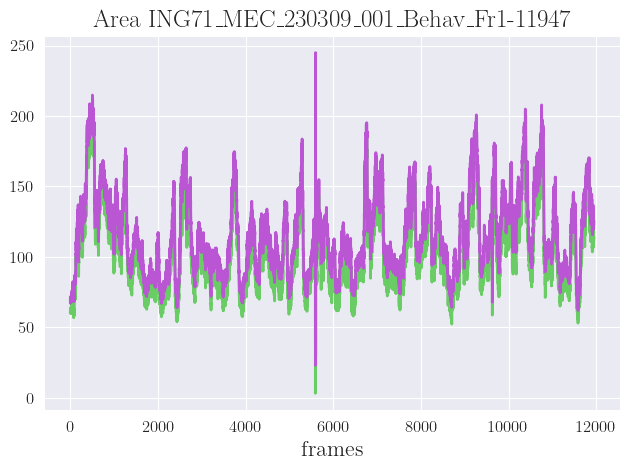

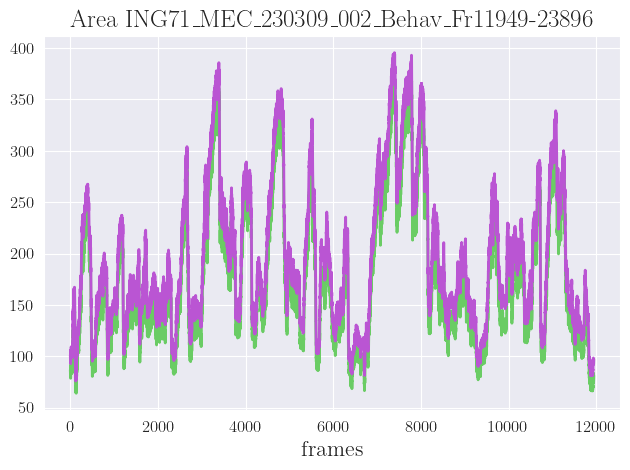

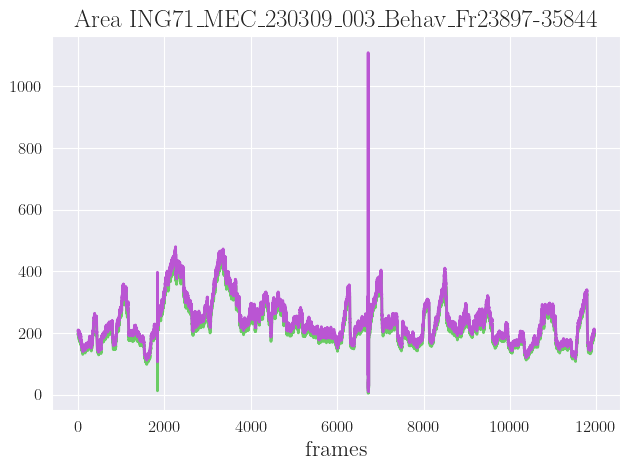

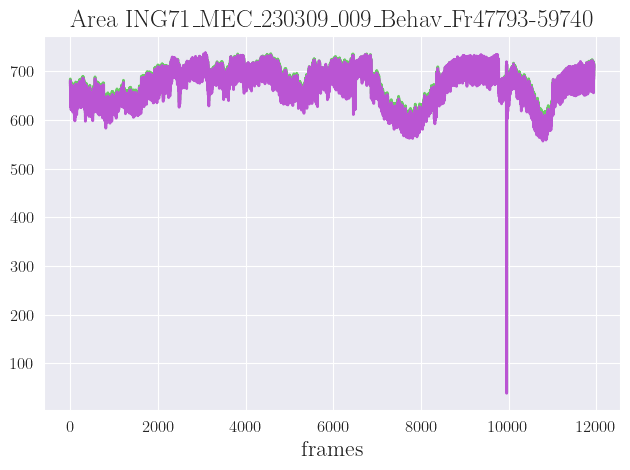

In [3]:
# Loading individuals and comparing:

proc_001_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_001_Behav_Fr1-11947_proc.npy', allow_pickle=True).item()
proc_001_gen = procs_general['ING71_MEC_230309_001_Behav_Fr1-11947_proc']

plot_area(proc_001_gen, show=False)
plot_area(proc_001_ind)


proc_002_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_002_Behav_Fr11949-23896_proc.npy', allow_pickle=True).item()
proc_002_gen = procs_general['ING71_MEC_230309_002_Behav_Fr11949-23896_proc']

plot_area(proc_002_gen, show=False)
plot_area(proc_002_ind)


proc_003_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_003_Behav_Fr23897-35844_proc.npy', allow_pickle=True).item()
proc_003_gen = procs_general['ING71_MEC_230309_003_Behav_Fr23897-35844_proc']

plot_area(proc_003_gen, show=False)
plot_area(proc_003_ind)


proc_009_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_009_Behav_Fr47793-59740_proc.npy', allow_pickle=True).item()
proc_009_gen = procs_general['ING71_MEC_230309_009_Behav_Fr47793-59740_proc']

plot_area(proc_009_gen, show=False)
plot_area(proc_009_ind)

Looks like the shape is kept rather constant although the absolute value seems to vary some. One can assume that some of this is due to the individual altering of saturation being better than the general one. Seems like the pupil is mostly within the defined region.  

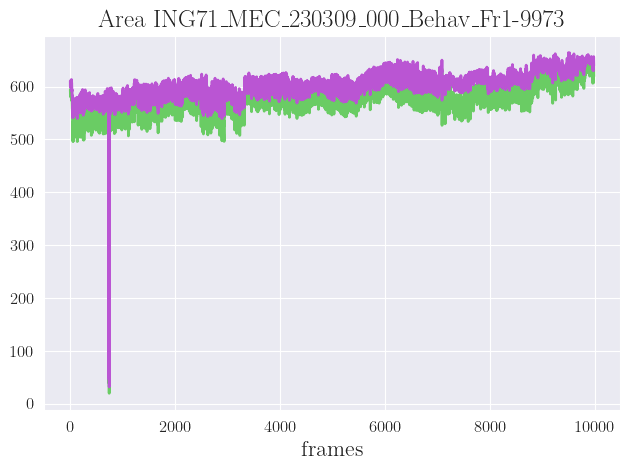

In [6]:

# Checkin the original one (should overlap completely):
proc_000_ind = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()
proc_000_gen = procs_general['ING71_MEC_230309_000_Behav_Fr1-9973_proc']

plot_area(proc_000_gen, show=False)
plot_area(proc_000_ind)

This is interesting! Not even the original one overlaps completely... Here the .npy-file was first processed in the GUI (yielding the green graph) and then that proc-file was used to process the entire folder (including the purple graph). Could it be that there is some randomness to the calculations which yield the difference in result? This was very interesting, indeed. Could it be that the saturation is not saved in the proc-file which is used for processing, but only employed when processing inside the GUI? This could be checked out 

#### Compare procs

In [7]:
print(proc_000_gen['rois'][0]['saturation'])
print(proc_000_ind['rois'][0]['saturation'])

124.95
153.0


Very interesting... It seems the saturation is different in the two 

In [8]:
print(proc_000_gen['rois'][0]['yrange'])
print(proc_000_ind['rois'][0]['yrange'])

print(proc_000_gen['rois'][0]['xrange'])
print(proc_000_ind['rois'][0]['xrange'])

[13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
[13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49]
[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


In [9]:
print(proc_000_gen['rois'][0]['ellipse'])
print(proc_000_ind['rois'][0]['ellipse'])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


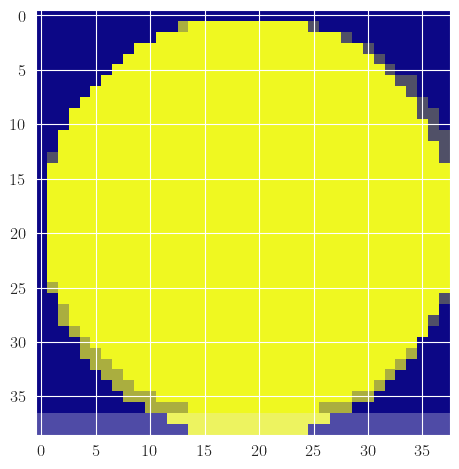

In [16]:
plt.imshow(proc_000_ind['rois'][0]['ellipse'], cmap='plasma')
plt.imshow(proc_000_gen['rois'][0]['ellipse'], alpha=0.7, cmap='plasma')
plt.show()

See that there is not a complete overlap between the two. 

#### Compare procs before and after processing
Would like to compare proc before and after processing (through facemap_tools)

Now with folder '/Volumes/T7/ING71_MEC_230317' (would have liked to try with the other mouse, but this is the only data I have access to at the moment.)

In [2]:
proc_b4_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_000_Behav_Fr1-9973_unproc_proc.npy', allow_pickle=True).item()
proc_af_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy/ING71_MEC_230317_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()

print(proc_b4_proc['rois'])
print(proc_af_proc['rois'])

[{'rind': 0, 'rtype': 'Pupil', 'iROI': 0, 'ivid': 0, 'color': (123.48366421773648, 228.01100458570562, 118.51165888740175), 'yrange': array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45], dtype=int32), 'xrange': array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58], dtype=int32), 'saturation': 127.5, 'pupil_sigma': 2.0, 'ellipse': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}]
[{'rind': 0, 'rtype': 'Pupil', 'iROI': 0, 'ivid': 0, 'color': (123.48366421773648

Seem to be identical! 

Would now like to process it trough the gui and compare it. 

In [21]:
proc_af_gui_proc = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_000_Behav_Fr1-9973_proc.npy', allow_pickle=True).item()

print(proc_b4_proc['rois'])
print(proc_af_gui_proc['rois'])

[{'rind': 0, 'rtype': 'Pupil', 'iROI': 0, 'ivid': 0, 'color': (123.48366421773648, 228.01100458570562, 118.51165888740175), 'yrange': array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45], dtype=int32), 'xrange': array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58], dtype=int32), 'saturation': 127.5, 'pupil_sigma': 2.0, 'ellipse': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}]
[{'rind': 0, 'rtype': 'Pupil', 'iROI': 0, 'ivid': 0, 'color': (123.48366421773648

What? This still seem identical...

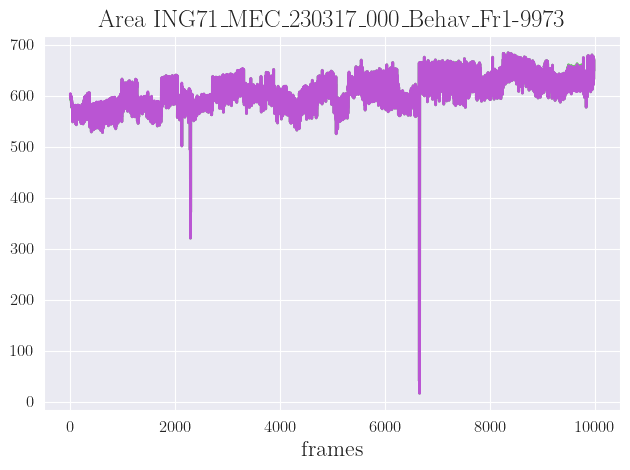

In [22]:
plot_area(proc_af_proc, show=False)
plot_area(proc_af_gui_proc)

Wait, so now it completely overlaps... What did I do before? Haha.

Perhaps I sent in the  wrong npy-file while processing the folder? Perhaps I sent in the wrong path and it ended up using sample or something?

In [32]:
# Look at sample.npy to see if this is the one who's been used 
proc_sample = np.load('/Users/annapaulinehjertvikaasen/Documents/2. UiO/Sommerjobb - Frederik/Sommerjobb 2023/MouseProject/MouseProjectGH/ING71_MEC_230309/AVI/sample.npy', allow_pickle=True).item()
print(proc_sample['rois'][0]['saturation'])

127.5


In [33]:
proc_sample_2 = np.load('/Volumes/T7/ING71_MEC_230309/AVI/ING71_MEC_230309_sample.npy', allow_pickle=True).item()
print(proc_sample_2['rois'][0]['saturation'])

124.95


Aha! Here we see what's happened! I have perhaps forgotten to send in the a path to the proc-file. 

However, when looking at the terminal history, this is not what happened. Looks like it should have used the path I sent in, also when looking at the function. 

![](figures/terminal.png)

To test this hypothesis though, we could process the ---_sample.npy file and compare. Should then see a complete overlap. If this is the case then the results above are valid. 


However, I cannot upload ---_sample.npy to the GUI since Eirik created that, hahah.


#### Next folder: '/Volumes/T7/ING71_MEC_230317'

In [4]:
procs_17_general = create_procs('/Volumes/T7/ING71_MEC_230317/AVI/resultsnpy')

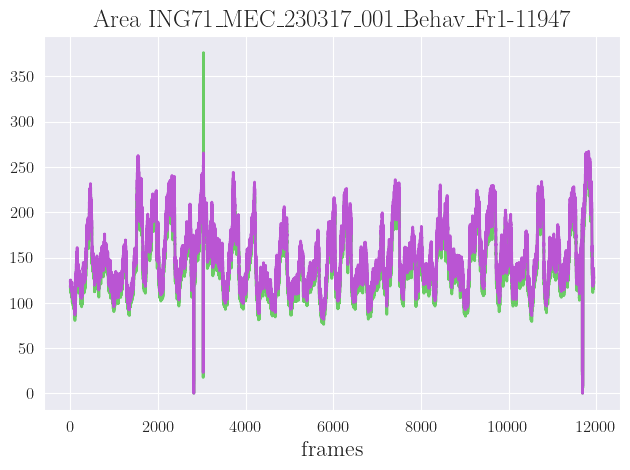

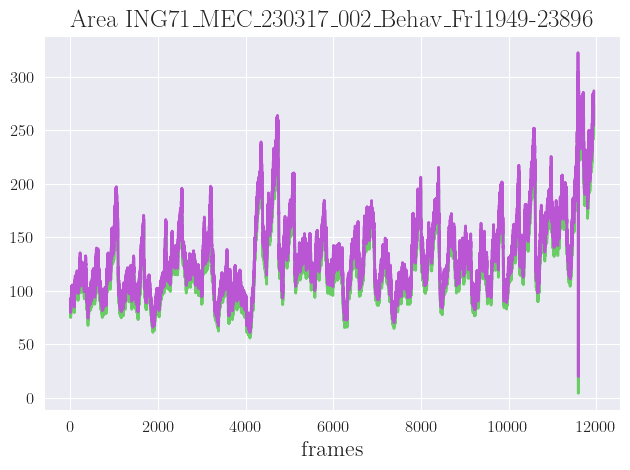

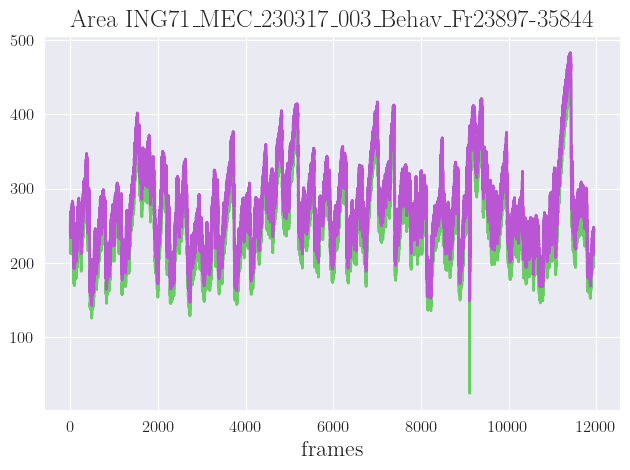

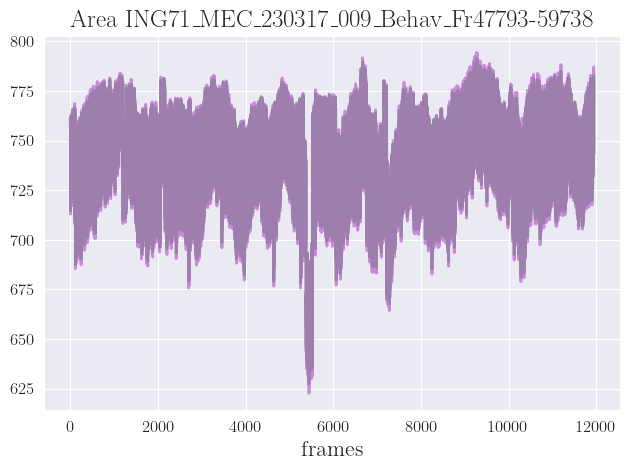

In [5]:
proc_17_001_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_001_Behav_Fr1-11947_proc.npy', allow_pickle=True).item()
proc_17_001_gen = procs_17_general['ING71_MEC_230317_001_Behav_Fr1-11947_proc']

plot_area(proc_17_001_gen, show=False)
plot_area(proc_17_001_ind)


proc_17_002_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_002_Behav_Fr11949-23896_proc.npy', allow_pickle=True).item()
proc_17_002_gen = procs_17_general['ING71_MEC_230317_002_Behav_Fr11949-23896_proc']

plot_area(proc_17_002_gen, show=False)
plot_area(proc_17_002_ind)


proc_17_003_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_003_Behav_Fr23897-35844_proc.npy', allow_pickle=True).item()
proc_17_003_gen = procs_17_general['ING71_MEC_230317_003_Behav_Fr23897-35844_proc']

plot_area(proc_17_003_gen, show=False)
plot_area(proc_17_003_ind)


proc_17_009_ind = np.load('/Volumes/T7/ING71_MEC_230317/AVI/ING71_MEC_230317_009_Behav_Fr47793-59738_proc.npy', allow_pickle=True).item()
proc_17_009_gen = procs_17_general['ING71_MEC_230317_009_Behav_Fr47793-59738_proc']

plot_area(proc_17_009_gen, show=False)
plot_area(proc_17_009_ind, alpha=0.65)